In [1]:
import os
import pickle as pkl

# import numpy as np
# import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import image_dataset_from_directory
from keras import layers
from matplotlib import pyplot as plt
import seaborn as sns

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
# print(f"Pandas {pd.__version__}")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0


### Downloading the Data

In [2]:
DATA_FOLDER = "./data"

hindi_handwritten_dataset_zip_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00389/DevanagariHandwrittenCharacterDataset.zip"
zip_file_name = hindi_handwritten_dataset_zip_url.rsplit('/', 1)[1]

TRAIN_FOLDER_NAME = "Train"
TEST_FOLDER_NAME = "Test"
DEVANAGARI_ZIP_PATH = os.path.join(DATA_FOLDER, zip_file_name)
DEVANAGARI_DATA_FOLDER = os.path.join(os.path.join(DATA_FOLDER, zip_file_name.rsplit(".")[0]))
print(DEVANAGARI_DATA_FOLDER)

./data/DevanagariHandwrittenCharacterDataset


In [3]:
# Download the dataset and de-compress
import requests
import zipfile

if not os.path.exists(DEVANAGARI_ZIP_PATH):
    req = requests.get(hindi_handwritten_dataset_zip_url, allow_redirects=True)
    # Writing the file to the local file system
    with open(DEVANAGARI_ZIP_PATH, 'wb') as output_file:
        output_file.write(req.content)
    print("Downloaded zip file")
else:
    print("Zip file already present")

if not os.path.exists(DEVANAGARI_DATA_FOLDER):
    with zipfile.ZipFile(DEVANAGARI_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_FOLDER)
    print("Extracted zip file")
else:
    print("Files already present on disk")

Zip file already present
Files already present on disk


### Removing classes we don't want

In [4]:
all_label_names = [
    'character_10_yna', 'character_11_taamatar', 'character_12_thaa', 'character_13_daa', 'character_14_dhaa',
    'character_15_adna', 'character_16_tabala', 'character_17_tha', 'character_18_da', 'character_19_dha',
    'character_1_ka', 'character_20_na', 'character_21_pa', 'character_22_pha', 'character_23_ba', 'character_24_bha',
    'character_25_ma', 'character_26_yaw', 'character_27_ra', 'character_28_la', 'character_29_waw', 'character_2_kha',
    'character_30_motosaw', 'character_31_petchiryakha', 'character_32_patalosaw', 'character_33_ha',
    'character_34_chhya', 'character_35_tra', 'character_36_gya', 'character_3_ga', 'character_4_gha',
    'character_5_kna', 'character_6_cha', 'character_7_chha', 'character_8_ja', 'character_9_jha', 'digit_0', 'digit_1',
    'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9'
]
labels_to_keep = [
    "digit_0", "digit_1", "digit_2", "digit_3", "digit_4", "digit_5", "digit_6", "digit_7", "digit_8", "digit_9"
]

In [5]:
import shutil
import glob

# We will only keep the Hindi digits in training data.
folders = glob.glob(os.path.join(DEVANAGARI_DATA_FOLDER, TRAIN_FOLDER_NAME, "*"))
# print(folders)
# print(folders[0].rsplit("/")[-1])
for f in folders:
    if f.rsplit("/")[-1] not in labels_to_keep:
        try:
            shutil.rmtree(f)
        except OSError as e:
            print("Error: %s : %s" % (f, e.strerror))

# Doing the same to test data.
folders = glob.glob(os.path.join(DEVANAGARI_DATA_FOLDER, TEST_FOLDER_NAME, "*"))
# print(folders)
# print(folders[0].rsplit("/")[-1])
for f in folders:
    if f.rsplit("/")[-1] not in labels_to_keep:
        try:
            shutil.rmtree(f)
        except OSError as e:
            print("Error: %s : %s" % (f, e.strerror))

### Dataset and Model Parameters

In [6]:
RANDOM_SEED = 42

# Data parameters
IMG_HEIGHT = 32
IMG_WIDTH = 32
VALIDATION_SPLIT = 0.1

# Model parameters
BATCH_SIZE = 32
KERNEL_SIZE = (3, 3)
MAX_POOLING_SIZE = (2, 2)
DROPOUT = 0.5

num_classes = len(labels_to_keep)

In [7]:
classes = labels_to_keep
classes_to_output_class_names = {
    "digit_0": "0", "digit_1": "1", "digit_2": "2", "digit_3": "3", "digit_4": "4", "digit_5": "5", "digit_6": "6",
    "digit_7": "7", "digit_8": "8", "digit_9": "9"
}
# output_classes = [
#     "ka", "kha", "ga", "gha", "kna", "cha", "chha", "ja", "jha", "yna", "t`a", "t`ha", "d`a", "d`ha", "adna", "ta",
#     "tha", "da", "dha", "na", "pa", "pha", "ba", "bha", "ma", "yaw", "ra", "la", "waw", "sha", "shat", "sa", "ha",
#     "aksha", "tra", "gya", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"
# ]

print("Gathering training dataset...")
train_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TRAIN_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Gathering validation dataset...")
val_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TRAIN_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

print("Gathering test dataset...")
test_dataset = image_dataset_from_directory(
    os.path.join(DEVANAGARI_DATA_FOLDER, TEST_FOLDER_NAME),
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    seed=RANDOM_SEED,
    validation_split=None,  # None, so that we get all the data.
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Gathering training dataset...
Found 17000 files belonging to 10 classes.
Using 15300 files for training.
Metal device set to: Apple M1
Gathering validation dataset...


2022-02-23 23:32:59.540309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-23 23:32:59.540429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 17000 files belonging to 10 classes.
Using 1700 files for validation.
Gathering test dataset...
Found 3000 files belonging to 10 classes.


In [8]:
train_dataset.element_spec

(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
class_names_to_labels = dict([(cls_name, lbl) for cls_name, lbl in zip(classes, list(range(len(classes))))])
# print(class_names_to_labels)
labels_to_class_names = dict([(v, k) for k, v in class_names_to_labels.items()])
print(labels_to_class_names)

{0: 'digit_0', 1: 'digit_1', 2: 'digit_2', 3: 'digit_3', 4: 'digit_4', 5: 'digit_5', 6: 'digit_6', 7: 'digit_7', 8: 'digit_8', 9: 'digit_9'}


### Look at the data
Let us take a look at the data after it has been stored as a tensorflow tf.Data.Dataset object.

(32, 32, 1)


2022-02-23 23:33:00.099011: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


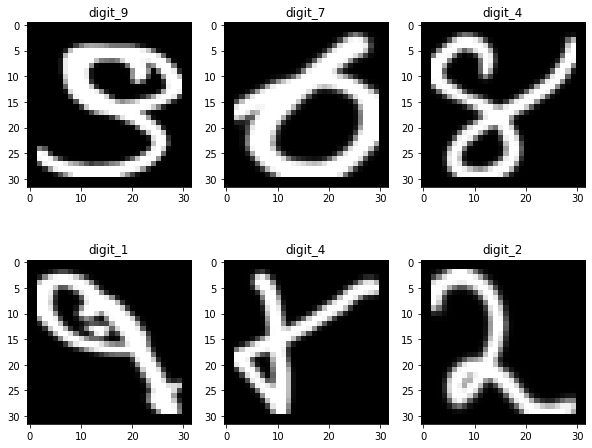

In [10]:
# Take a look at the input data
rows = 2
columns = 3
fig = plt.figure(figsize=(10, 8))
j = 1
for images, labels in train_dataset.take(1):
    print(images[0].shape)
    for i, l in zip(images[:6], labels[:6]):
        fig.add_subplot(rows, columns, j)
        plt.imshow(tf.squeeze(i), cmap='gray', vmin=0, vmax=255)
        plt.title(labels_to_class_names[int(l)])
        j += 1

### Data Augmentation and Normalisation
#### Normalisation

The values of pixels in the images range from `[0, 255]`.

We should normalize the values to be in the `[0, 1]` range.

The purpose of Normalisation is to make values measured on different scales to be all "squished" or "expanded" to a common scale/range such as `[0, 1]`.
This ensures that each variable in the data is given an equal importance and no variable influences the model parameters more than any other purely because it's values are larger.

We will perform the normalization using <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling"><code>tf.keras.layers.Rescaling</code></a>.

#### Augmentation
Augmenting the data allows us to ensure that the model doesn't just learn something that's common for the entire class, but has no meaning when it comes to classification.

For example, consider a dataset with blue cars and red cars.

If all the blue cars are facing to the right and all red cars are facing left, then the model will end up being influenced by the orientation of the car in the image, thus producing incorrect predications when you ask the model to predict, say, the color of a blue car facing to the left.

By performing augmentations such as Flipping, Rotations, Zooming, Shearing, Translations etc, we prevent the model from learning/memorizing features which are irrelevant.

In [11]:
# Scale images to the [0, 1] range
normalization_layer = layers.Rescaling(1. / 255)
# Data Augmentations
with tf.device('/CPU:0'):
    data_augmentation_layers = keras.Sequential(
        [
            # layers.RandomFlip("horizontal",
            #                   input_shape=(IMG_HEIGHT,
            #                                IMG_WIDTH,
            #                                1)),
            # layers.RandomRotation(0.1),
            layers.RandomZoom(0.05),
            layers.RandomTranslation(0.05, 0.05),
        ]
    )

### Prefetch and Caching
Learn about tf.data.Dataset Prefetching here: <https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch>
Learn about tf.data.Dataset Caching here: <https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache>

In [12]:
# prefetching and caching data to improve performance.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### Checking Data Augmentation

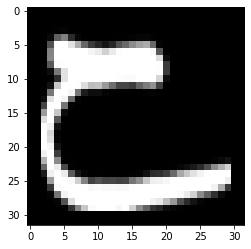

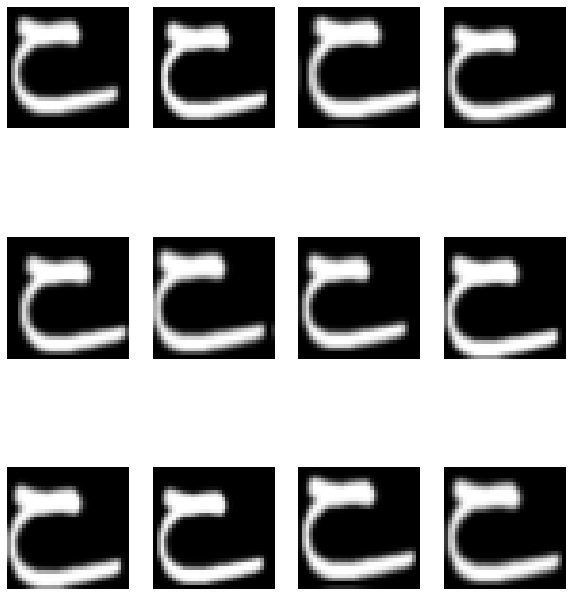

In [13]:
rows = 3
columns = 4
for images, _ in train_dataset.take(1):
    plt.imshow(tf.squeeze(images[0]), cmap='gray', vmin=0, vmax=255)
    fig = plt.figure(figsize=(10, 12))
    for i in range(12):
        with tf.device('/CPU:0'):
            augmented_images = data_augmentation_layers(images)
        fig.add_subplot(rows, columns, i + 1)
        # plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.imshow(tf.squeeze(augmented_images[0]), cmap='gray', vmin=0, vmax=255)
        plt.axis("off")

### Creating the Model

First, we'll add the `data_augmentation_layers` and the `normalization_layer`, following which we'll create a convolutional neural network.

Learn more about CNNs here: <https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/>

In [14]:
model = keras.Sequential(
    [
        data_augmentation_layers,
        normalization_layer,
        layers.Conv2D(32, kernel_size=KERNEL_SIZE, activation="relu"),
        layers.MaxPooling2D(pool_size=MAX_POOLING_SIZE),
        layers.Conv2D(64, kernel_size=KERNEL_SIZE, activation="relu"),
        layers.MaxPooling2D(pool_size=MAX_POOLING_SIZE),
        layers.Dropout(DROPOUT),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

### Compiling and Building Model
Note that we are using Categorical Crossentropy as the loss function, and this is well suited for categorical output data.
Read more here: <https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression>

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 32, 32, 1)           0         
                                                                 
 rescaling (Rescaling)       (32, 32, 32, 1)           0         
                                                                 
 conv2d (Conv2D)             (32, 30, 30, 32)          320       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 15, 15, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 13, 13, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 6, 6, 64)           0         
 2D)                                                  

In [16]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15


/Users/anurags/miniforge3/envs/tensorflow_exp/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-02-23 23:33:01.336773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8952

2022-02-23 23:33:09.665198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


479/479 [==============================] - 9s 18ms/step - loss: 0.3290 - accuracy: 0.8952 - val_loss: 0.0485 - val_accuracy: 0.9865
Epoch 2/15
479/479 [==============================] - 8s 17ms/step - loss: 0.0899 - accuracy: 0.9727 - val_loss: 0.0420 - val_accuracy: 0.9871
Epoch 3/15
479/479 [==============================] - 8s 17ms/step - loss: 0.0578 - accuracy: 0.9808 - val_loss: 0.0216 - val_accuracy: 0.9924
Epoch 4/15
479/479 [==============================] - 8s 17ms/step - loss: 0.0450 - accuracy: 0.9856 - val_loss: 0.0171 - val_accuracy: 0.9935
Epoch 5/15
479/479 [==============================] - 8s 17ms/step - loss: 0.0373 - accuracy: 0.9882 - val_loss: 0.0191 - val_accuracy: 0.9918
Epoch 6/15
479/479 [==============================] - 8s 17ms/step - loss: 0.0345 - accuracy: 0.9892 - val_loss: 0.0086 - val_accuracy: 0.9976
Epoch 7/15
479/479 [==============================] - 8s 17ms/step - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.0097 - val_accuracy: 0.9965
Epoch 8/15

### Measuring Performance on Training and Test Data

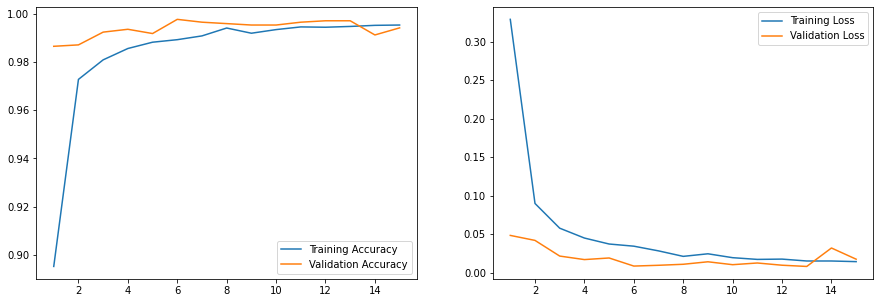

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs + 1)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 2, 1)
sns.lineplot(x=epochs_range, y=acc, legend='brief', label='Training Accuracy')
sns.lineplot(x=epochs_range, y=val_acc, legend='brief', label='Validation Accuracy')

fig.add_subplot(1, 2, 2)
sns.lineplot(x=epochs_range, y=loss, legend='brief', label='Training Loss')
sns.lineplot(x=epochs_range, y=val_loss, legend='brief', label='Validation Loss')
plt.show()

### Metrics

| Data       | Accuracy | Loss   |
|:-----------|:--------:|-------:|
| Training   | 99.52%   | 0.0139 |
| Validation | 99.65%   | 0.0107 |

<!-- Training Accuracy: 99.52%

Validation Accuracy: 99.65%

Training Loss: 0.0139

Validation Loss: 0.0107 -->


We can see that the model's accuracy and validation accuracy quickly went up during and after the first epoch and then it saturated around epoch #10. 

Training and validation loss also fell dramatically after the second epoch, and reached a saturation around epoch #11.

In [18]:
print("Evaluate")
result = model.evaluate(test_dataset)
result = dict(zip(model.metrics_names, result))

Evaluate
94/94 [==============================] - 1s 8ms/step - loss: 0.0242 - accuracy: 0.9953


### Test Metrics

| Data | Accuracy |   Loss |
|:-----|:--------:|-------:|
| Test |  99.56%  | 0.0189 |

#### Overall this is a great result, and it shows that the model has generalized properly and has low variance, while having high bias.

### Saving the Model

In [19]:
MODEL_FOLDER = "./models"
HINDI_MNIST_FOLDER = "hindi_mnist"
MODEL_SAVE_FOLDER = os.path.join(MODEL_FOLDER, HINDI_MNIST_FOLDER)
MODEL_SAVE_PATH = os.path.join(MODEL_FOLDER, HINDI_MNIST_FOLDER, "model.h5")
# pickle files
CLASSES_PKL_FILE = "classes.pickle"
CLASSES_PKL_PATH = os.path.join(MODEL_SAVE_FOLDER, CLASSES_PKL_FILE)

In [20]:
model.save(
    MODEL_SAVE_PATH, overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

In [21]:
with open(CLASSES_PKL_PATH, 'wb') as f:
    pkl.dump(classes, f)
    pkl.dump(labels_to_class_names, f)

In [22]:
# Delete model and labels_to_class_names to check if we correctly saved the model by loading it from disk and re-evaluating on test data.
del model
del classes
del labels_to_class_names

In [23]:
import pickle as pkl
from keras.models import load_model

In [24]:
model = load_model(MODEL_SAVE_PATH)

with open(CLASSES_PKL_PATH, 'rb') as f:
    classes = pkl.load(f)
    labels_to_class_names = pkl.load(f)

In [25]:
print("Evaluate")
result = model.evaluate(test_dataset)
result = dict(zip(model.metrics_names, result))
print(result)

Evaluate
19/94 [=====>........................] - ETA: 0s - loss: 0.0088 - accuracy: 0.9984

/Users/anurags/miniforge3/envs/tensorflow_exp/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-02-23 23:35:04.809043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 6ms/step - loss: 0.0242 - accuracy: 0.9953
{'loss': 0.024181803688406944, 'accuracy': 0.9953333139419556}
